In [2]:
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import os, psutil
import scipy 
import warnings

In [3]:
class CIR:
    def __init__(self, tau, alpha, beta, seed=None):
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.rng = (
            default_rng(np.round(np.pi * 1e10).astype(int)) 
            if seed is None else default_rng(seed)
        )

    def sample_wiener_increments(self, num_realizations, num_timepoints, delta_t):
        return (
            self.rng.standard_normal((num_realizations, num_timepoints)) 
            * np.sqrt(delta_t)
        )

    def sample_ncx2(self, dof, lambda_):
        return scipy.stats.ncx2.rvs(dof, lambda_, random_state=self.rng)

    def __call__(self, x_0, num_realizations, num_timesteps, delta_t, method):
        # TODO: add validation logic for x_0 (should be 1D array)

        # Preallocate and set initial value.
        x = np.full((num_realizations, num_timesteps), fill_value=np.nan)
        x[:, 0] = x_0

        if method == 'euler_maruyama':
            dW = self.sample_wiener_increments(num_realizations, num_timesteps, delta_t)
            kappa = 1 / self.tau
            sigma = np.sqrt(2 / (self.tau * self.beta))
            theta = self.alpha / self.beta
            for i_timestep in range(num_timesteps-1):
                dX = (
                    kappa * (theta - x[:, i_timestep]) * delta_t
                    + sigma * np.sqrt(x[:, i_timestep]) * dW[:, i_timestep]
                )
                x[:, i_timestep+1] = x[:, i_timestep] + dX

            # Collect params to be returned.
            params = {
                'kappa' : kappa,
                'theta' : theta, 
                'sigma' : sigma
            }

        elif method == 'ncx2':
            # Precompute necessary parameters for sampling.
            kappa = 1 / self.tau
            sigma_sqr = 2 / (self.tau * self.beta)
            upsilon = np.exp(-kappa * delta_t)
            eta = (
                4 * kappa * upsilon 
                / (sigma_sqr * (1 - upsilon))
            )
            dof = 4 * kappa * (self.alpha / self.beta) / sigma_sqr

            # Iteratively update via sampling.
            for i_timestep in range(num_timesteps-1):
                x[:, i_timestep + 1] \
                    = self.sample_ncx2(dof, eta * x[:, i_timestep])
                
            # Collect params to be returned.
            params = {
                'kappa' : kappa,
                'sigma_sqr' : sigma_sqr,
                'eta' : eta,
                'dof' : dof
            }

        return x, params



In [4]:
# Rate = alpha/beta.
params = {
    'cir' : {
        '1' : {
            'alpha' : 2,
            'beta' : 0.5,
            'tau' : 1
        },
        '2' : {
            'alpha' : 2,
            'beta' : 0.5,
            'tau' : 1
        },
        '12' : {
            'alpha' : 2,
            'beta' : 0.5,
            'tau' : 1
        },
    },
    'simulation' : {
        'num_realizations' : 2,
        'num_timesteps' : 50000,
        'delta_t' : 0.001, # 0.000125, 
        'method' : 'euler_maruyama'
    }
}
params['simulation']['x_0'] = np.zeros((params['simulation']['num_realizations'],))

# Prepare seeds. Can save entropy of seed_seq for reproducibility.
seed_seq = np.random.SeedSequence()
child_seeds = seed_seq.spawn(3)
for i_process, process in enumerate(params['cir'].keys()):
    params['cir'][process]['seed'] = child_seeds[i_process]

# Instantiate callable CIR objects.
cir = {key : CIR(**params['cir'][key]) for key in ['1', '2', '12']}


### Create rate functions r_1, r_2, and r['12']

/var/folders/02/23gpmqxd5lb81qt2g18pxrwh0000gn/T/ipykernel_5907/2635789037.py:35: RuntimeWarning: invalid value encountered in sqrt
  + sigma * np.sqrt(x[:, i_timestep]) * dW[:, i_timestep]


[[ 0.          0.004       0.00824567 -0.00220682         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan 

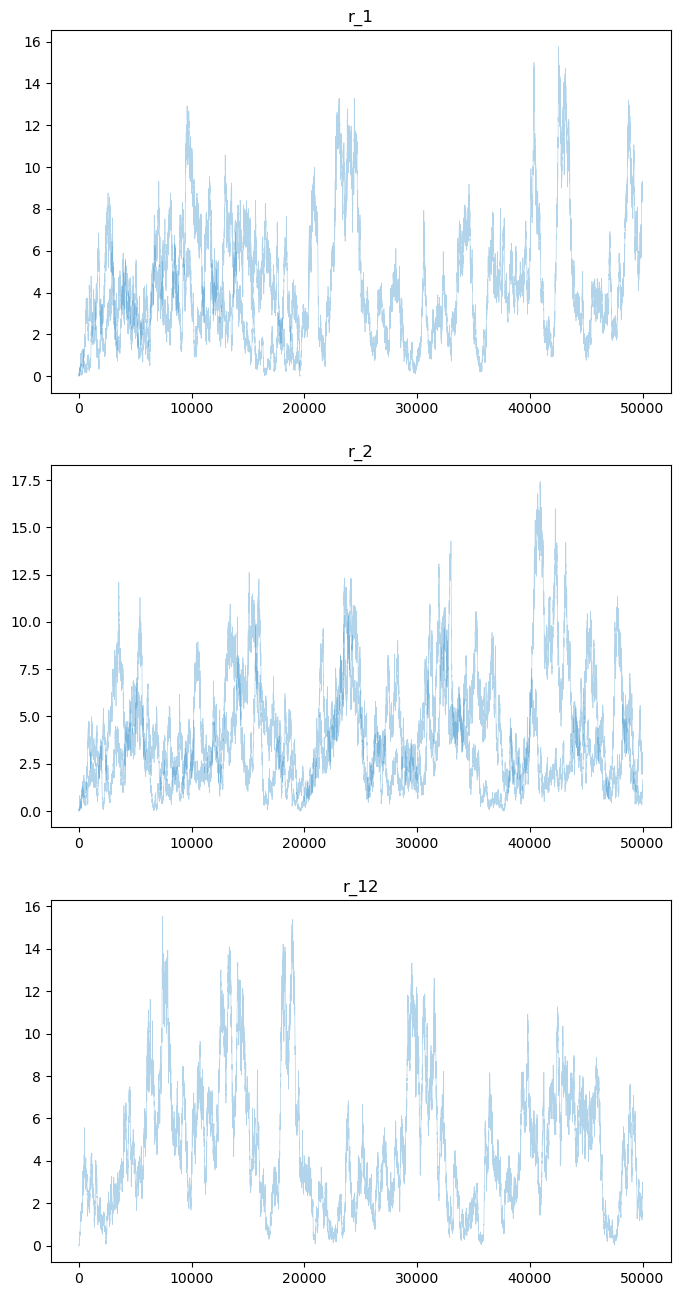

In [16]:
r = {key : cir[key](**params['simulation'])[0] for key in ['1', '2', '12']}

print(r['12'][:, :200])
fig_0, axs_0 = plt.subplots(3, 1, figsize=(8, 16))

for i_process, process in enumerate(r.keys()):
    for i_realization in range(r[process].shape[0]):
        axs_0[i_process].plot(r[process][i_realization, :], color=(0, 0.4470, 0.741), alpha=0.3, linewidth=0.5)
        axs_0[i_process].set_title(f"r_{process}")

### Simulate Poisson process

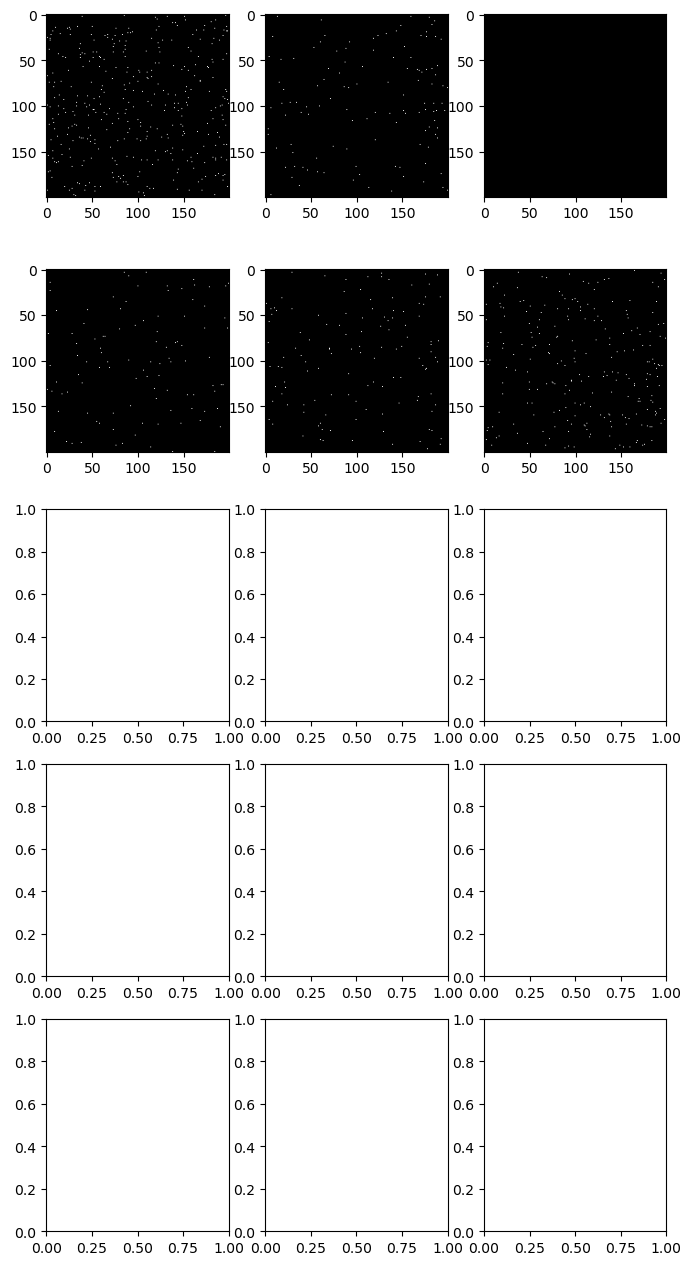

In [18]:
def generate_spikes(r, rng, num_inputs, num_timesteps, delta_t):
    """ 
    """
    if r.ndim != 1: 
        raise ValueError(f"`r` should be a 1d array, but got a {r.ndim}d array.")
    
    lambda_ = r * delta_t
    p = lambda_ * np.exp(-lambda_)
    u = rng.random((num_inputs, num_timesteps))
    spikes = (p[np.newaxis, :] > u).astype(int)

    # Convert dtype for space efficiency.
    return spikes.astype(np.int8)

# Set parameters for generating spikes.
params['poisson_process'] = {
    'num_shared_inputs' : 500,
    'num_independent_inputs' : 500
}

# Prepare for plotting.
num_rows, num_cols = 5, 3
fig_1, axs_1 = plt.subplots(num_rows, num_cols, figsize=(8, 16))

# Precompute shapes of spike arrays for preallocation below.
spikes = dict()
spikes['1'] = np.full(
    (
        params['simulation']['num_realizations'],
        params['poisson_process']['num_independent_inputs'],
        params['simulation']['num_timesteps']
    ),
    -1, # No -1's should remain after assignment
    dtype=np.int8
)
spikes['2'] = copy.deepcopy(spikes['1'])
spikes['12'] = np.full(
    (
        params['simulation']['num_realizations'],
        params['poisson_process']['num_shared_inputs'],
        params['simulation']['num_timesteps']
    ),
    -1, # No -1's should remain after assignment
    dtype=np.int8
)

# Generate spiking input.
for i_realization in range(params['simulation']['num_realizations']):
    for process in ['1', '2', '12']:
        # Get number of inputs for current spikes matrix.
        num_inputs = (
            params['poisson_process']['num_shared_inputs'] if process == '12' 
            else params['poisson_process']['num_independent_inputs']
        )
        # Generate spikes.
        spikes[process][i_realization, :, :] = generate_spikes(
            r[process][i_realization, :],
            cir[process].rng,
            num_inputs,
            params['simulation']['num_timesteps'],
            params['simulation']['delta_t']
        )

        # Plot spikes.
        if i_realization <= num_rows-1:
            i_row = i_realization
            i_col = 0 if process == '1' else 1 if process == '2' else 2
            axs_1[i_row, i_col].imshow(spikes[process][i_realization, :200, 10000:10200], cmap='gray')
        # i_row, i_col = divmod(i_realization, 2)
        # if i_row <= num_rows-1 and i_col <= num_cols-1:
        #     axs_1[i_row, i_col].imshow(spikes['12'][i_realization, :100, 1000:1200], cmap='gray')
    

In [20]:
# Set parameters for computing conductance timeseries.
params['conductance_process'] = {
    'membrane_tau' : 0.02,
    'h' : np.array([0.001]), # synaptic conductance
}

# Can specify single weight for all input synapses, or one for each.
params['neuron'] = {
    '1' : {
        'w' : 0.001
    },
    '2' : {
        'w' : 0.001
    },
    '12' : {
        'w' : 0.001
    }
}

params['postsynaptic_membrane'] = {
    'tau' : np.array([0.005]),
    'v_e' : np.array([70]),
    'v_0' : np.array([0]),
}

def compute_jump(w_e, v_e, v_prev):
    jump = (v_e - v_prev) * (1 - np.exp(-w_e))
    print(jump)
    return jump

def relaxation(v_t, v_e, w_e, delta_t, num_spikes, num_timesteps_to_next_spikes, membrane_tau):
    jump = compute_jump(w_e * num_spikes, v_e, v_t)
    t = np.arange(num_timesteps_to_next_spikes) * delta_t
    v = (v_t + jump) * np.exp(-t/membrane_tau)
    return v


voltages = np.zeros(
    (params['simulation']['num_realizations'], 2, params['simulation']['num_timesteps']),
)

for i_realization in range(params['simulation']['num_realizations']):
    for i_neuron_idx, neuron_idx in enumerate(['1', '2']):
        # Get number of inputs for current spikes matrix.
        num_inputs = (
            params['poisson_process']['num_shared_inputs'] if process == '12' 
            else params['poisson_process']['num_independent_inputs']
        )

        all_input_spikes = np.concatenate(
                (
                    spikes[neuron_idx][i_realization, :, :], 
                    spikes['12'][i_realization, :, :]
                ),
        )
        all_input_counts = np.sum(all_input_spikes, axis=0)
        if (all_input_counts > 1).any(): 
            print('Some time bins have more than one spike.')
        spike_times = (np.where(all_input_counts)[0]).astype(int)
        
        # voltage = np.full((all_input_counts.shape), fill_value=np.nan)
        for i_spike_time, spike_time in enumerate(spike_times):
            # Compute number of timesteps from current spike to next one (inclusive).
            num_timesteps_to_next_spikes = (
                (spike_times[i_spike_time+1] - spike_time) + 1 # Plus one to make it inclusive
                if i_spike_time < len(spike_times) - 1 
                else params['simulation']['num_timesteps'] - spike_time
            ) 

            if params['simulation']['num_timesteps'] - 200 <= spike_time < params['simulation']['num_timesteps']:
                a = 1

            v = relaxation(
                voltages[i_realization, i_neuron_idx, spike_time],
                params['postsynaptic_membrane']['v_e'],
                params['neuron'][neuron_idx]['w'],
                params['simulation']['delta_t'],
                all_input_counts[spike_time],
                num_timesteps_to_next_spikes,
                params['postsynaptic_membrane']['tau']
            )

            voltages[i_realization, i_neuron_idx, spike_time:spike_time+num_timesteps_to_next_spikes] = v
            
        
      


Some time bins have more than one spike.
[0.06996501]
[0.06995982]
[0.06996389]
[0.06993308]
[0.06996417]
[0.06995543]
[0.06996436]
[0.069965]
[0.06990775]
[0.06986092]
[0.06982262]
[0.06982279]
[0.06979143]
[0.06985567]
[0.06992083]
[0.06988855]
[0.06994083]
[0.06990194]
[0.06995693]
[0.06990115]
[0.06989162]
[0.06996492]
[0.06991808]
[0.06995441]
[0.06989909]
[0.06996426]
[0.06994372]
[0.13985736]
[0.06993651]
[0.06994875]
[0.06990724]
[0.06996152]
[0.06992472]
[0.06996133]
[0.06990475]
[0.06987778]
[0.06985972]
[0.06990059]
[0.06994281]
[0.06995255]
[0.06989756]
[0.06987297]
[0.06983247]
[0.1397113]
[0.06982151]
[0.06982204]
[0.0698224]
[0.06982263]
[0.06984857]
[0.06984016]
[0.13954151]
[0.13959167]
[0.13949321]
[0.06974853]
[0.1394766]
[0.06974297]
[0.06972614]
[0.13935509]
[0.06982084]
[0.13957339]
[0.13948098]
[0.13932154]
[0.06963042]
[0.06974319]
[0.06972633]
[0.06979577]
[0.06985762]
[0.06984622]
[0.13955142]
[0.06980372]
[0.13948193]
[0.06984413]
[0.06980889]
[0.06984104]
[0

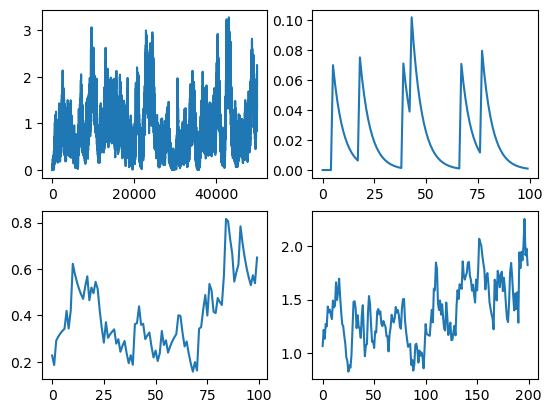

In [21]:
fig_2, axs_2 = plt.subplots(2, 2)

axs_2[0, 0].plot(voltages[0, 0, :])  
axs_2[0, 1].plot(voltages[0, 0, :100])  
axs_2[1, 0].plot(voltages[0, 0, 20000:20100])  
axs_2[1, 1].plot(voltages[0, 0, -200:])  